In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "*****",
                             database = "ecommerce")

cur = db.cursor()

# Provide a list of distinct cities where customers are based.

In [9]:
query = 'SELECT DISTINCT customer_city FROM customers'

cur.execute(query)

data = cur.fetchall()

dataset = pd.DataFrame(data)
dataset.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Calculate the total number of orders placed during the year 2017.

In [12]:
query = "SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"

# Execute the query
cur.execute(query)

# Fetch the result
order_count_2017 = cur.fetchone()[0]

# Display the result
print("Number of orders placed in 2017:", order_count_2017)

Number of orders placed in 2017: 45101


# Calculate the total sales for each category.

In [14]:
query = """
    SELECT upper(products.product_category) category,round(sum(payments.payment_value),2) sales
    from products join order_items 
    on products.product_id = order_items.product_id
    join payments 
    on payments.order_id = order_items.order_id
    group by category
"""

# Execute the query
cur.execute(query)

# Fetch the result
data = cur.fetchall()

# Convert the result into a pandas DataFrame
dataset = pd.DataFrame(data, columns=['category', 'total_sales'])

dataset


,category,total_sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Determine the percentage of orders that were paid using installments.

In [21]:
query = 'SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS installment_percentage FROM payments'

cur.execute(query)

data = cur.fetchall()

print("the percentage of orders that were paid in installments is:", data[0][0])

the percentage of orders that were paid in installments is: 99.9981


# Count the number of customers residing in each state.

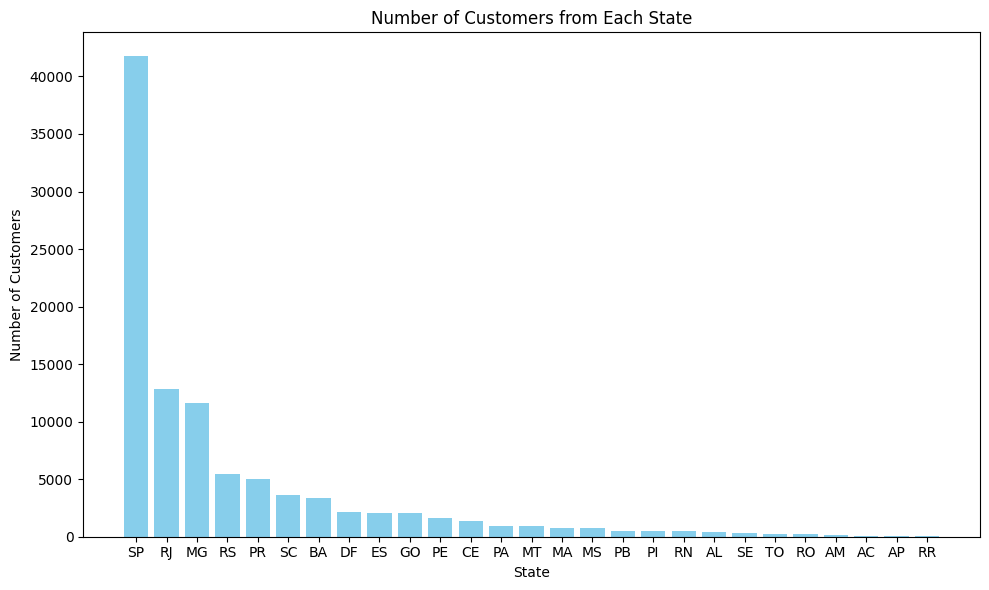

In [30]:
query = ' select customer_state ,count(customer_id) from customers group by customer_state '

cur.execute(query)

data = cur.fetchall()
dataset = pd.DataFrame(data, columns = ["state", "customer_count" ])
dataset = dataset.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize=(10, 6))
plt.bar(dataset['state'], dataset['customer_count'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.title('Number of Customers from Each State') 
plt.tight_layout()

plt.show()

# Determine the total number of orders placed each month throughout 2018.

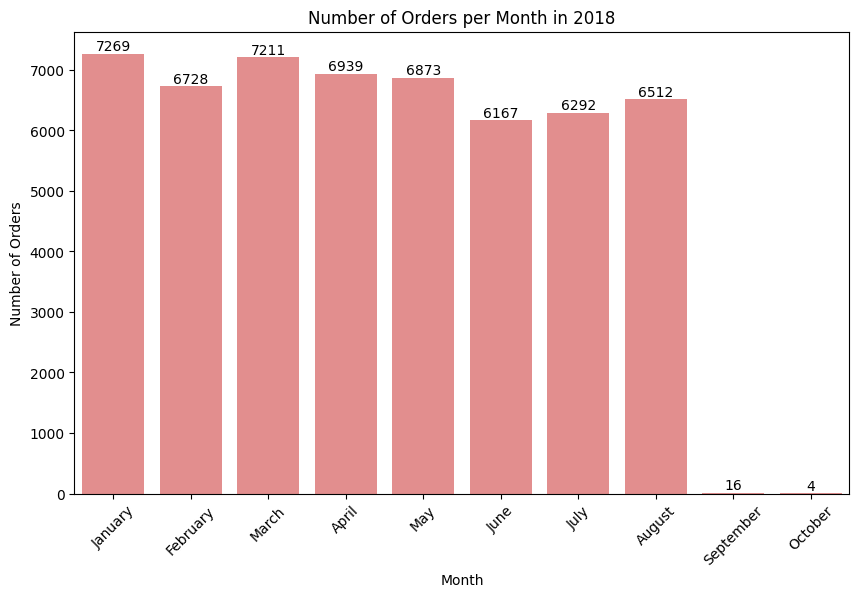

In [57]:
query = """
    SELECT MONTHNAME(order_purchase_timestamp) AS month, COUNT(order_id) AS order_count
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2018
    GROUP BY month
"""

cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
dataset = pd.DataFrame(data, columns=['month', 'order_count'])
month_labels = ["January", "February","March","April","May","June","July","August","September","October"]

# Plot the data using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month', y='order_count', data=dataset, order=month_labels, color='lightcoral')

ax.bar_label(ax.containers[0])

plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Month in 2018')
plt.xticks(rotation=45)
plt.show()

# Determine the average quantity of products per order for each city where customers are located.

In [58]:
query = """
WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC
"""

cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
dataset = pd.DataFrame(data, columns=["customer city", "average products/order"])

# Display the first 10 rows of the DataFrame
dataset.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [60]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)
data = cur.fetchall()
dataset = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
dataset.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [61]:
cur = db.cursor()

# SQL query to get product price and the count of purchases
query = """
SELECT 
    products.product_category,
    count(order_items.product_id),
    round(avg(order_items.price),2)
FROM 
    products join order_items 
    on products.product_id = order_items.product_id
GROUP BY 
    products.product_category
"""

cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
dataset = pd.DataFrame(data, columns=["Category", "order_count","price"])

# Calculate the correlation
correlation = dataset['order_count'].corr(dataset['price'])

# Display the correlation
print(f"Correlation between product price and purchase count: {correlation:.2f}")


Correlation between product price and purchase count: -0.11


# Calculate the total revenue generated by each seller, and rank them by revenue.

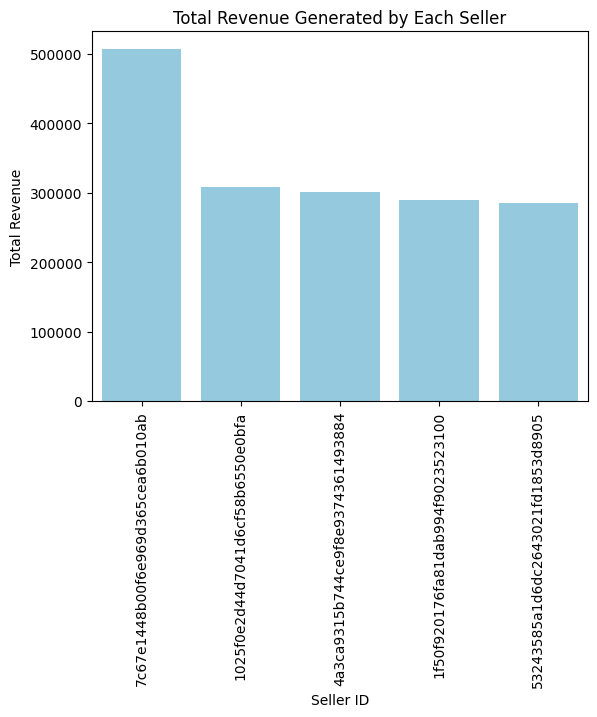

In [73]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
dataset = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
dataset = dataset.head()
sns.barplot(x = "seller_id", y = "revenue", data = dataset, color='skyblue')
plt.xlabel('Seller ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Generated by Each Seller')
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [78]:
query = """
SELECT 
    customer_id,
    order_purchase_timestamp,
    payment,
    avg(payment) over(partition by customer_id order by order_purchase_timestamp
    rows between 2 preceding and current row) as mov_avg
FROM 
    (select orders.customer_id, orders.order_purchase_timestamp, 
    payments.payment_value as payment
FROM
    payments
JOIN 
    orders
    on payments.order_id = orders.order_id) as a
"""

cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
dataset = pd.DataFrame(data, columns=["customer_id","order_purchase_timestamp", "payment_value", "mov_avg"])
dataset.head()


,customer_id,order_purchase_timestamp,payment_value,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [80]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
dataset = pd.DataFrame(data, columns=["Years","Months", "Sales", "cumulative_sales"])
dataset

,Years,Months,Sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [81]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        years 
    ORDER BY 
        years
)

SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) / 
     LAG(payment, 1) OVER (ORDER BY years)) * 100 AS "yoy % growth"
FROM 
    a
"""

cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
dataset = pd.DataFrame(data, columns=["years", "yoy % growth"])
dataset


,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [82]:
query = """
WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM 
        customers 
    JOIN 
        orders ON customers.customer_id = orders.customer_id
    GROUP BY 
        customers.customer_id
),

b AS (
    SELECT 
        a.customer_id, 
        COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM 
        a 
    JOIN 
        orders ON orders.customer_id = a.customer_id
    WHERE 
        orders.order_purchase_timestamp > first_order
        AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY 
        a.customer_id
) 

SELECT 
    100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) AS retention_rate
FROM 
    a 
LEFT JOIN 
    b ON a.customer_id = b.customer_id;
"""

cur.execute(query)
dataset = cur.fetchall()
dataset



[(None,)]

# Identify the top 3 customers who spent the most money in each year.

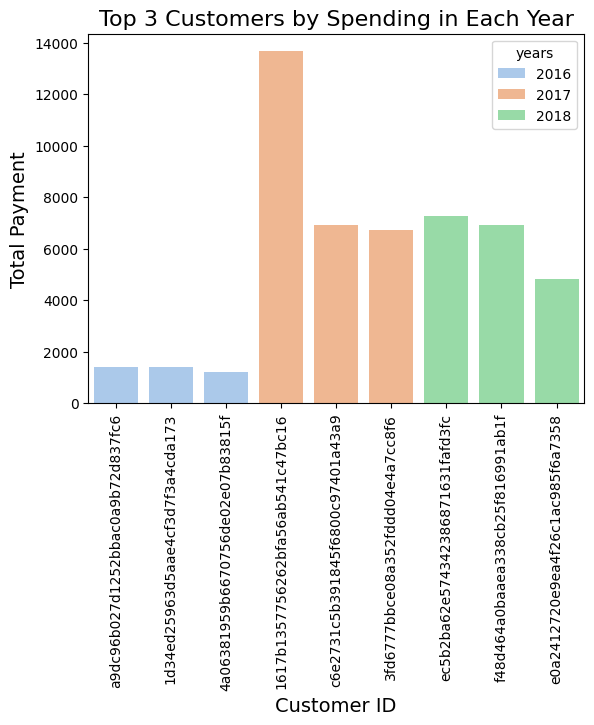

In [85]:
query = """
SELECT 
    years, 
    customer_id, 
    payment, 
    d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM 
        orders 
    JOIN 
        payments ON payments.order_id = orders.order_id
    GROUP BY 
        YEAR(orders.order_purchase_timestamp),
        orders.customer_id
) AS a
WHERE 
    d_rank <= 3;
"""


cur.execute(query)
data = cur.fetchall()
dataset = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = dataset, hue = "years", palette="pastel")
plt.title('Top 3 Customers by Spending in Each Year', fontsize=16)
plt.xlabel('Customer ID', fontsize=14)
plt.ylabel('Total Payment', fontsize=14)
plt.xticks(rotation = 90)
plt.show()
